In [24]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File("./RML2016.10a.tar.bz2") # open the file
data = zipfile.read() # get the decompressed data

In [25]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [26]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./RadioML_data') # specify which folder to extract to
my_tar.close()

In [27]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("./RadioML_data/RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [28]:
# Import all the things we need ---
%matplotlib inline
import random
import keras.models as models
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [29]:
# Partition the data
# into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
print(X_test.shape)

(110000, 2, 128)


In [30]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [31]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [32]:
dr = 0.6 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256,1, 1, activation="relu", name="conv1"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256,1, 1, activation="relu", name="conv2"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80,1, 1, activation="relu", name="conv3"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80,1, 1, activation="relu", name="conv4"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256,activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes),name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 6, 256)         33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 6, 256)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 1, 10, 256)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 10, 256)        65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 10, 256)       

In [33]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 5000  # training batch size

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [35]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN_woPCA.wts.h5'

import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
18/18 - 13s - loss: 2.3975 - accuracy: 0.0930 - val_loss: 2.3952 - val_accuracy: 0.1426
Epoch 2/100
18/18 - 12s - loss: 2.3558 - accuracy: 0.1219 - val_loss: 2.2540 - val_accuracy: 0.1443
Epoch 3/100
18/18 - 12s - loss: 2.2496 - accuracy: 0.1424 - val_loss: 2.2158 - val_accuracy: 0.1510
Epoch 4/100
18/18 - 12s - loss: 2.2234 - accuracy: 0.1511 - val_loss: 2.2078 - val_accuracy: 0.1577
Epoch 5/100
18/18 - 12s - loss: 2.2044 - accuracy: 0.1580 - val_loss: 2.1679 - val_accuracy: 0.1763
Epoch 6/100
18/18 - 12s - loss: 2.1679 - accuracy: 0.1639 - val_loss: 2.1383 - val_accuracy: 0.1736
Epoch 7/100
18/18 - 12s - loss: 2.1440 - accuracy: 0.1660 - val_loss: 2.0968 - val_accuracy: 0.1789
Epoch 8/100
18/18 - 12s - loss: 2.1054 - accuracy: 0.1795 - val_loss: 2.0184 - val_accuracy: 0.2430
Epoch 9/100
18/18 - 12s - loss: 2.0458 - accuracy: 0.2124 - val_loss: 1.9439 - val_accuracy: 0.2663
Epoch 10/100
18/18 - 12s - loss: 2.0026 - accuracy: 0.2324 - val_loss: 1.9139 - val_accuracy: 0.2877

In [36]:
# Show simple version of performance
score1 = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
score2 = model.evaluate(X_valid, y_valid, verbose=0, batch_size=batch_size)
score3 = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score1)
print(score2)
print(score3)

[1.5958627462387085, 0.3892613649368286]
[1.6325777769088745, 0.38109090924263]
[1.633384108543396, 0.3797454535961151]


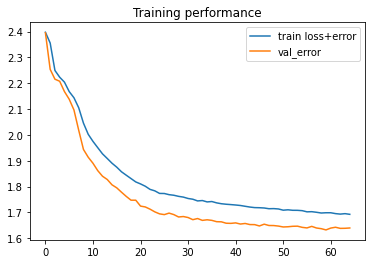

In [37]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

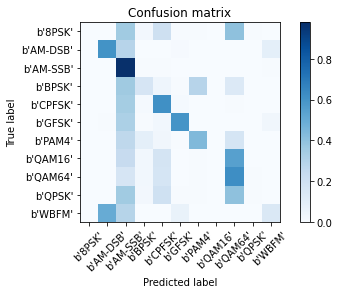

In [39]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [40]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09141522988505747 for SNR b'-20'
Overall Accuracy:  0.09582040518342763 for SNR b'-18'
Overall Accuracy:  0.09394157951676885 for SNR b'-16'
Overall Accuracy:  0.09162399414776884 for SNR b'-14'
Overall Accuracy:  0.10169794459338695 for SNR b'-12'
Overall Accuracy:  0.18245355894794923 for SNR b'-10'
Overall Accuracy:  0.29752218934911245 for SNR b'-8'
Overall Accuracy:  0.41129179608989586 for SNR b'-6'
Overall Accuracy:  0.5082466833990678 for SNR b'-4'
Overall Accuracy:  0.524328249818446 for SNR b'-2'
Overall Accuracy:  0.5255420801176038 for SNR b'0'
Overall Accuracy:  0.5250362844702468 for SNR b'2'
Overall Accuracy:  0.5176578225068619 for SNR b'4'
Overall Accuracy:  0.5235736562098697 for SNR b'6'
Overall Accuracy:  0.5093491549802229 for SNR b'8'
Overall Accuracy:  0.5059619149314825 for SNR b'10'
Overall Accuracy:  0.5153832150009102 for SNR b'12'
Overall Accuracy:  0.5286624203821656 for SNR b'14'
Overall Accuracy:  0.5190519598906107 for SNR b'16'
Over

In [41]:
print(acc_array)

[0.09141522988505747, 0.09582040518342763, 0.09394157951676885, 0.09162399414776884, 0.10169794459338695, 0.18245355894794923, 0.29752218934911245, 0.41129179608989586, 0.5082466833990678, 0.524328249818446, 0.5255420801176038, 0.5250362844702468, 0.5176578225068619, 0.5235736562098697, 0.5093491549802229, 0.5059619149314825, 0.5153832150009102, 0.5286624203821656, 0.5190519598906107, 0.5310192023633677]


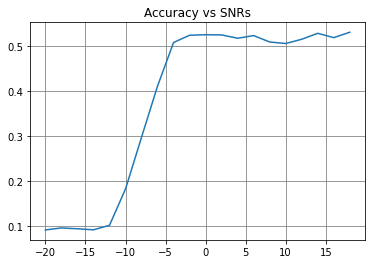

In [42]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), acc_array)